# Quality check of OPM sensors
The aim of this section is to conduct a basic quality check of set of OPM sensors and identifying the bad sensors. This will be done by calculating the power spectra for each sensor as well as showing a few examples.

## Import the necessary modules
Below are the required Python modules to be imported

In [1]:
import mne
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import array
from matplotlib.ticker import ScalarFormatter
from mne_bids import (
    BIDSPath,
    make_dataset_description,
    print_dir_tree,
    read_raw_bids,
)

## File Overview

The chapter relies on the input file (embedded in the BIDS structure)

```
<BIDS_ROOT>/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_meg.fif
```

## Data Loading

The first step is to prepare the data for reading. The OPM data, which is restructured according to the BIDS format will be used in this section for subsequent analysis.This requires creating the mne_bids.BIDSPath which point to the path of MNE BIDS folder.

#### Specify your BIDS parameters along with the BIDS folder path

In [2]:
subject = '01'  
session = '01'  
task = 'SpAtt'
run = '01'  
meg_suffix = 'meg'
meg_extension = '.fif'
events_suffix = 'events'
events_extension = '.tsv'

data_path='C:/Users/rakshita/Documents/Cerca_raw_files'
bids_root = op.join(data_path, "Cerca_Spatt_BIDS")
bids_path = BIDSPath(subject=subject, session=session,
                     task=task, run=run, suffix=meg_suffix, 
                     extension=meg_extension, root=bids_root)

#### We now created the BIDSPath object, let's read the OPM data

In [3]:
raw = read_raw_bids(bids_path=bids_path, verbose=False,extra_params={'preload':True})

#### Print the info of the raw data to get the details of about it.

In [4]:
raw.info

<Info | 16 non-empty values
 bads: []
 ch_names: Trigger 1, Trigger 2, Trigger 3, Trigger 4, Trigger 5, Trigger ...
 chs: 27 Stimulus, 192 Magnetometers
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dev_head_t: MEG device -> head transform
 device_info: 2 items (dict)
 dig: 15603 items (3 Cardinal, 15600 Extra)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 250.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 219
 projs: []
 sfreq: 750.0 Hz
 subject_info: <subject_info | his_id: sub-01, sex: 0, hand: 0>
>

## Annotate the bad channels

Here we will mark the bad channels in the raw data based on our findings during the data acquistion. Later the bad channels list will be extended based on the power spectral density estimate.

In [5]:
ch_names = raw.info['ch_names']
bad_chs = ['B4', 'H6']
bad_channels = [name for name in ch_names if any(ch in name for ch in bad_chs)]
raw.info['bads'] = bad_channels
raw.save
# Print the bad channels 
print("Bad channels marked:", raw.info['bads'])

Bad channels marked: ['T14 H6 Z', 'T14 H6 Y', 'T14 H6 X', 'AFz B4 Z', 'AFz B4 Y', 'AFz B4 X']


## Estimating the PSDs
As a first step calcualte the PSDs of all the sensors for A 1-120 HZ frequency range using the MNE functions. The PSD values are converted to decibel (dB) with respect to the reference of $1fT^2/Hz$ power. As such the result units are $dB [fT^2/Hz]$. Also note that the sampling frequency 5000 Hz and therefore chose $N_{FFT}$ = 10000 to achive a 0.5 Hz spectral resolution. 

In [6]:
n_fft=1500
raw_PSD = raw.compute_psd(method="welch", fmin=1, fmax=120, picks="mag", n_fft=n_fft, n_overlap=int(n_fft/2))
psds = raw_PSD.get_data() # units are in T^2/Hz
freqs = raw_PSD.freqs 

Effective window size : 2.000 (s)


#### Plot the PSD of all OPM Channels

Plotting power spectral density (dB=True).


C:\Users\rakshita\AppData\Local\mne-python\1.9.0_0\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


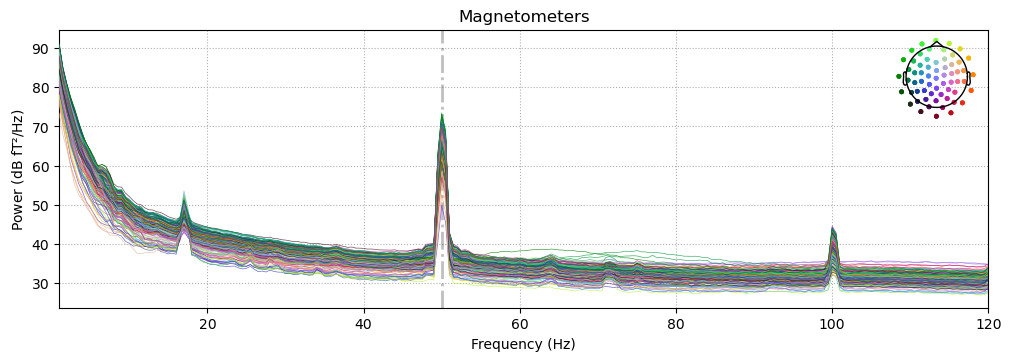

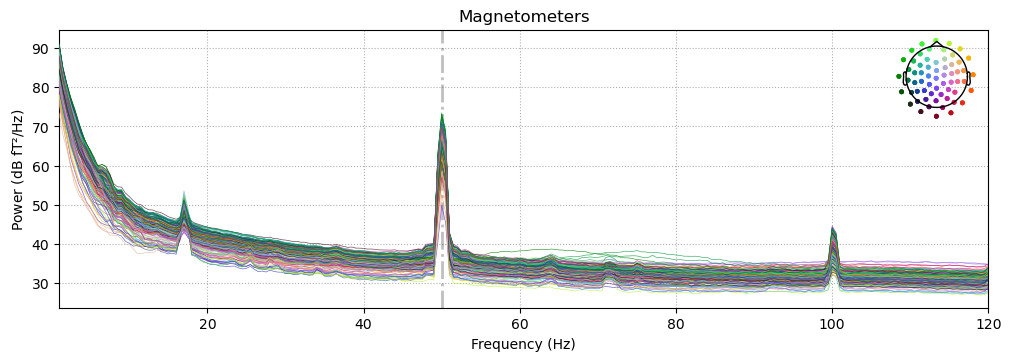

In [7]:
raw_PSD.plot(exclude='bads')

## Ranking the PSDs according to average power

To rank the sensors based on the average power, compute the average power of each sensor and sort them accordingly.

In [8]:
# Convert to db
avg_psd = [10 * np.log10(psd * 1e30) for psd in psds] # Ref power: 1fT^2=1e-30T^2
average_power = np.mean(avg_psd, axis=1)
## Get Only MEG channels
mag_channels = mne.pick_types(raw.info, meg=True, stim=False)
channel_names = [raw.info['ch_names'][i] for i in mag_channels]

ch_power_data = list(zip(channel_names, average_power, avg_psd))
ch_power_data_s = sorted(ch_power_data, key=lambda x: x[1], reverse=True) # Sorting by average power

s_channel_names = [channel for channel, power, psd in ch_power_data_s] #Sorted Channel names
s_average_power = [power for channel, power, psd in ch_power_data_s]
s_psds = [psd for channel, power, psd in ch_power_data_s]

## Plot the PSD of each sensor according to their rank 
As a next step the sensors for each PSD will be plotted. Note the scale of the power is the same for all sensors.

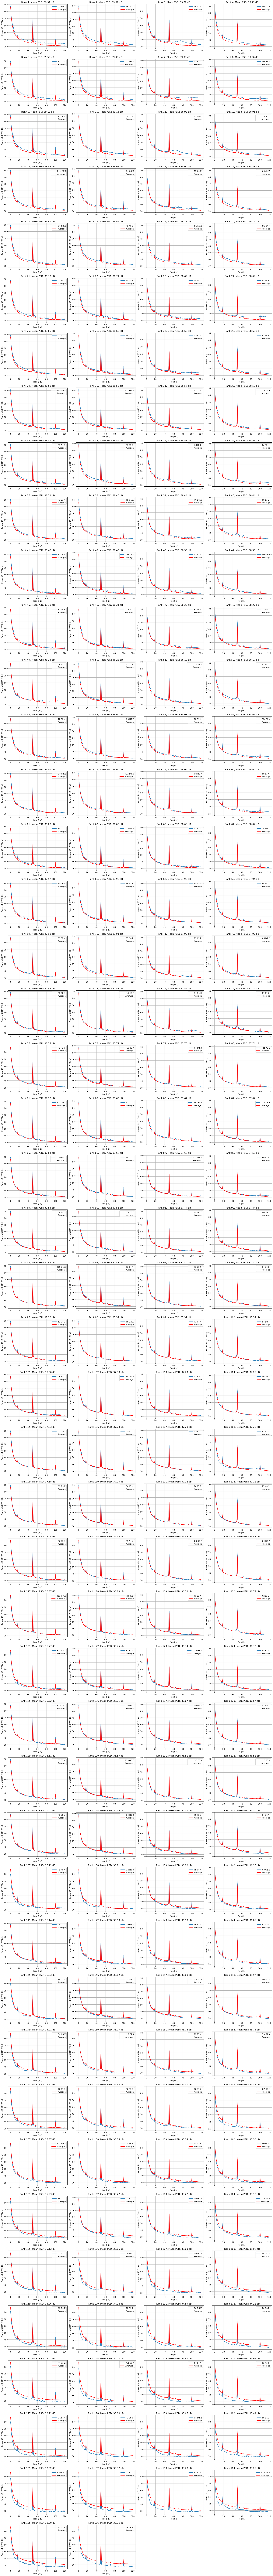

In [9]:
n_channels = len(s_channel_names)
n_cols = 4  
n_rows = 47

ymin = 20 
ymax = 70 
grand_avg_psd = np.mean(s_psds, axis=0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for rank, (channel, avg_power, psd) in enumerate(ch_power_data_s):
    ax = axes[rank]
    ax.plot(freqs, psd, label=f'{channel}')
    ax.plot(freqs, grand_avg_psd, label='Average', color='red')
    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel('Power dB [fT^2/Hz]')
    avg_psd_value = np.mean(psd)
    ax.set_title(f'Rank {rank + 1}, Mean PSD: {avg_psd_value:.2f} dB')
    #ax.set_ylim(ymin, ymax)
    ax.legend()
    ax.grid(True)

# Delete remaining unused subplots
for ax in axes[len(s_channel_names):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

## A Bar Chart Over the Sensor Power 
To get on overview of the power across sensors make a bar chart.

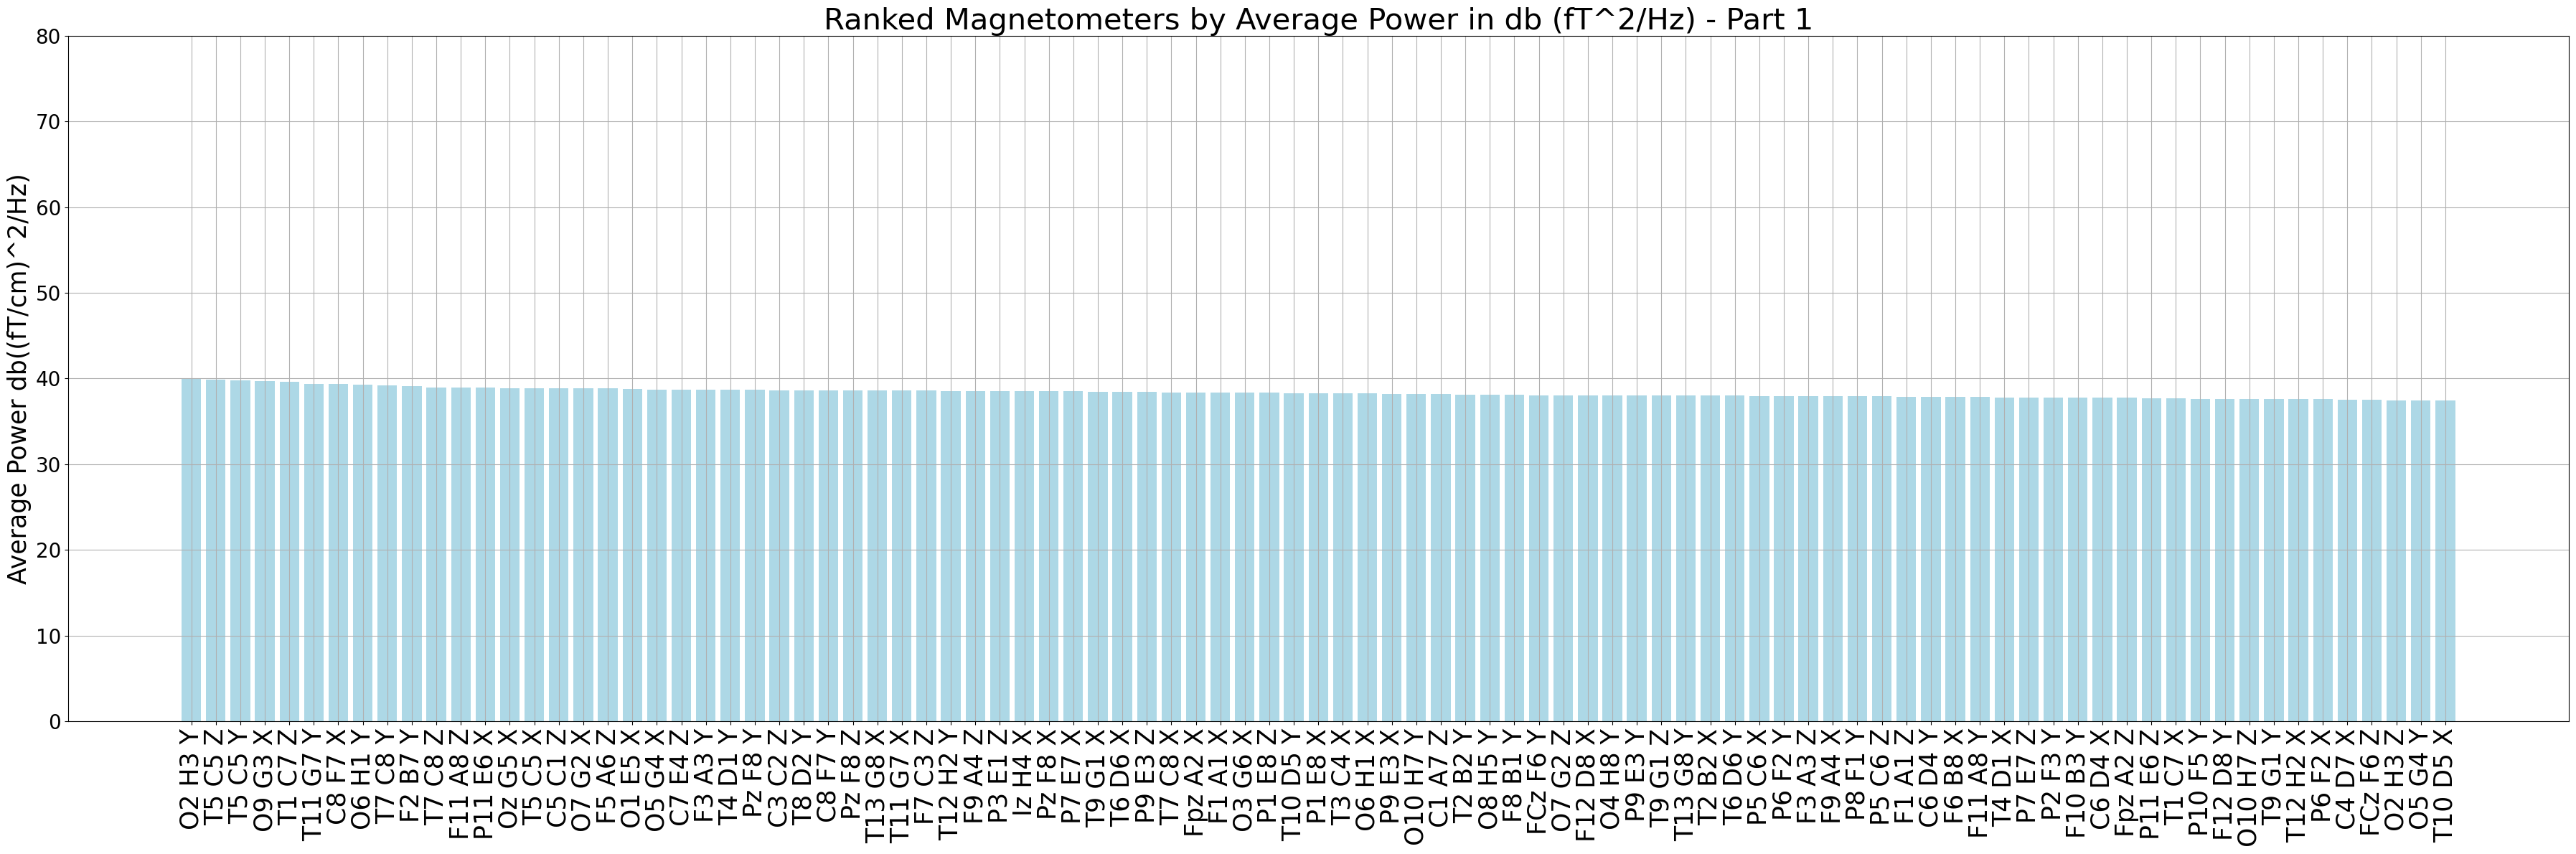

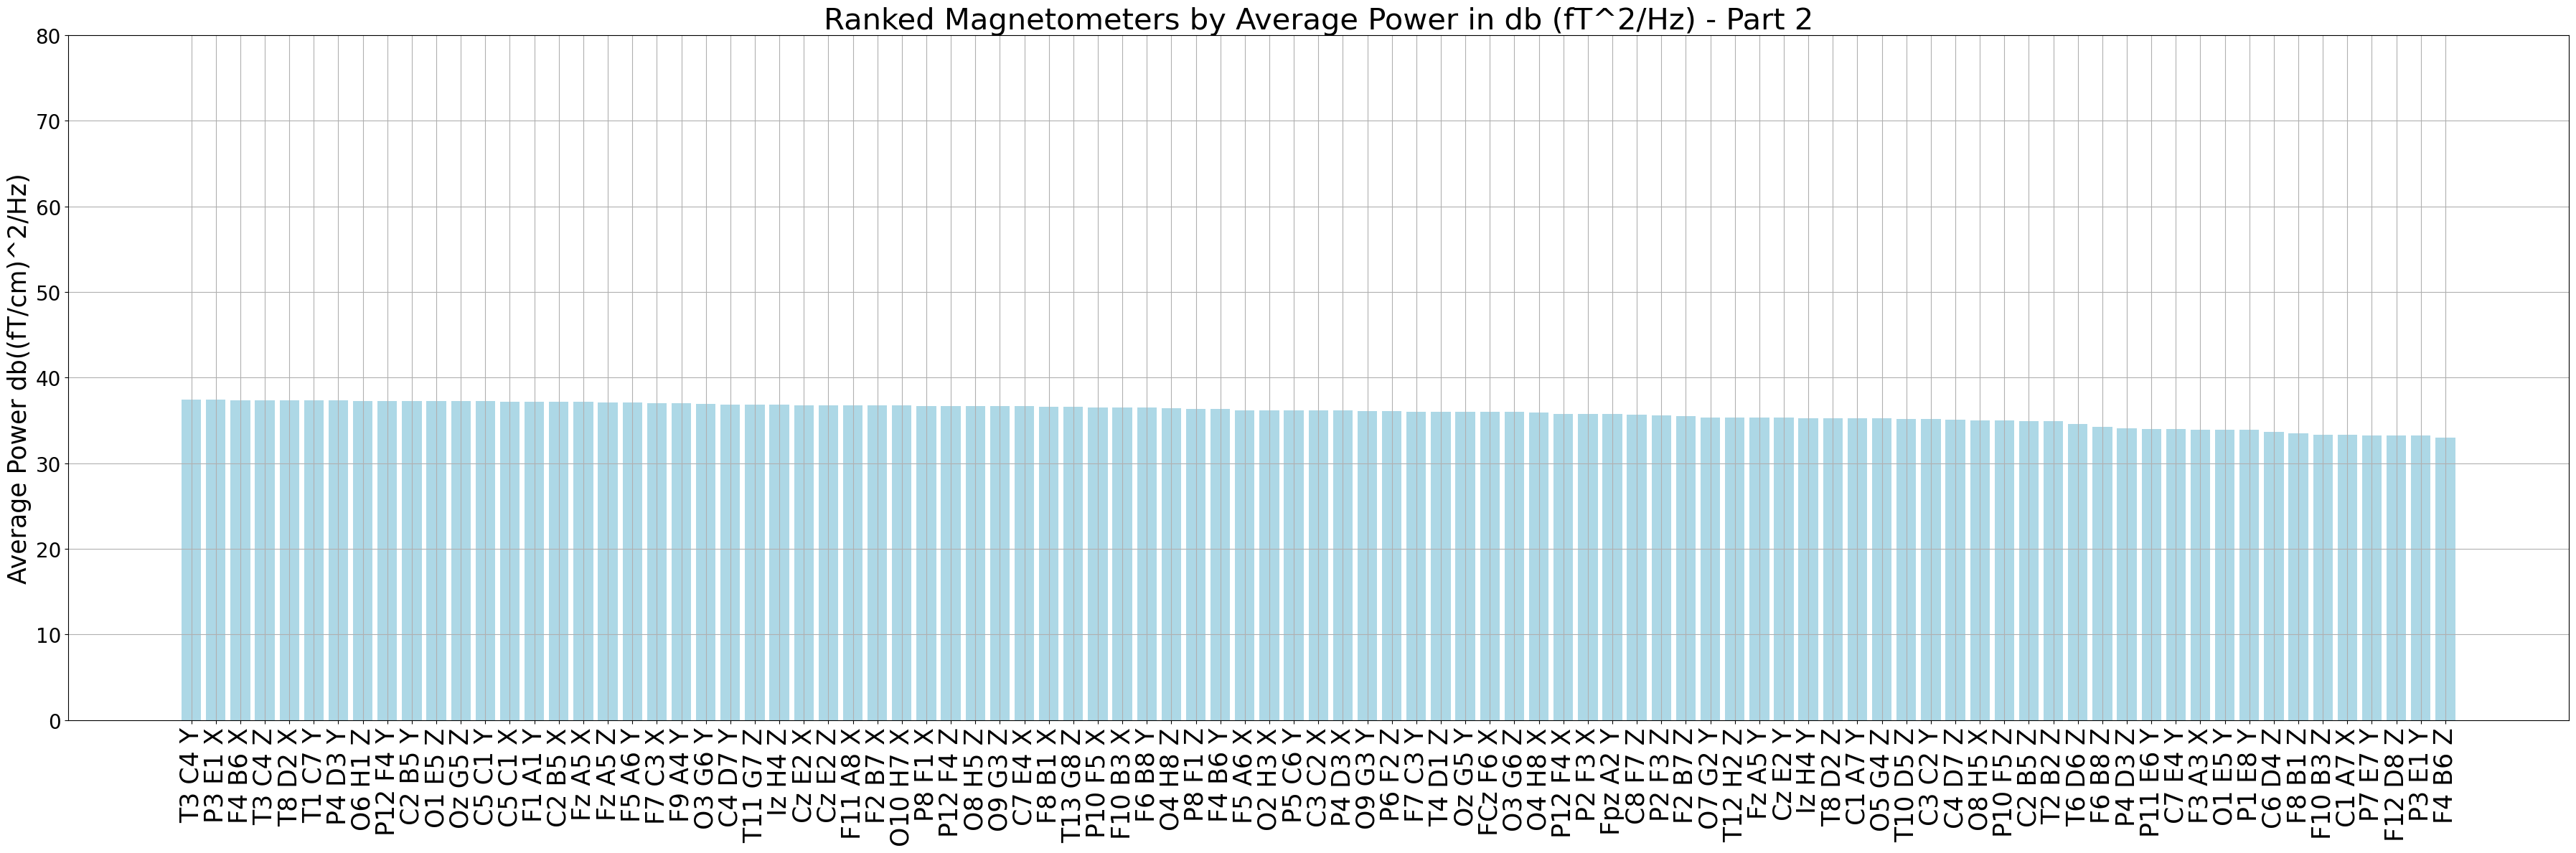

In [10]:
bars = 93  # Number of sensors per plot
num_plots = (len(s_channel_names) + bars - 1) // bars  # Total number of plots
y_min, y_max = 0, 80

for i in range(num_plots):
    start = i * bars
    end = min(start + bars, len(s_channel_names))
    
    plt.figure(figsize=(36, 12))
    plt.bar(s_channel_names[start:end], s_average_power[start:end], color='lightblue')
    plt.ylabel('Average Power db((fT/cm)^2/Hz)', fontsize=25)
    plt.title(f'Ranked Magnetometers by Average Power in db (fT^2/Hz) - Part {i + 1}', fontsize=30)
    plt.xticks(rotation=90, fontsize=25)
    plt.yticks(fontsize=20)
    plt.ylim(y_min, y_max)  
    plt.grid(True)
    plt.tight_layout()
    # Uncomment below to save each plot as an image
    # plt.savefig(f"bar_plot_part_{i + 1}.jpg", format='jpg', dpi=300)
    plt.show()


## Plotting the Time Course of Representative Sensors  
To get an overview of the time-course of the sensor activity, plot the time course of the 3 most noisy and 3 least noisy raw sensor over the full time-window

#### Identifying the most and least noisy channels

In [11]:
plot_channels = s_channel_names[:3] + s_channel_names[-3:]
most_noisy_channels = s_channel_names[:3]
least_noisy_channels = s_channel_names[-3:]

print("3 most noisy channel names:", most_noisy_channels)
print("3 least noisy channel names:", least_noisy_channels)

3 most noisy channel names: ['O2 H3 Y', 'T5 C5 Z', 'T5 C5 Y']
3 least noisy channel names: ['F12 D8 Z', 'P3 E1 Y', 'F4 B6 Z']


#### Plot the time course of above sensors
The least noisy sensors are marked with blue and most noisy sensors are marked with red.

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


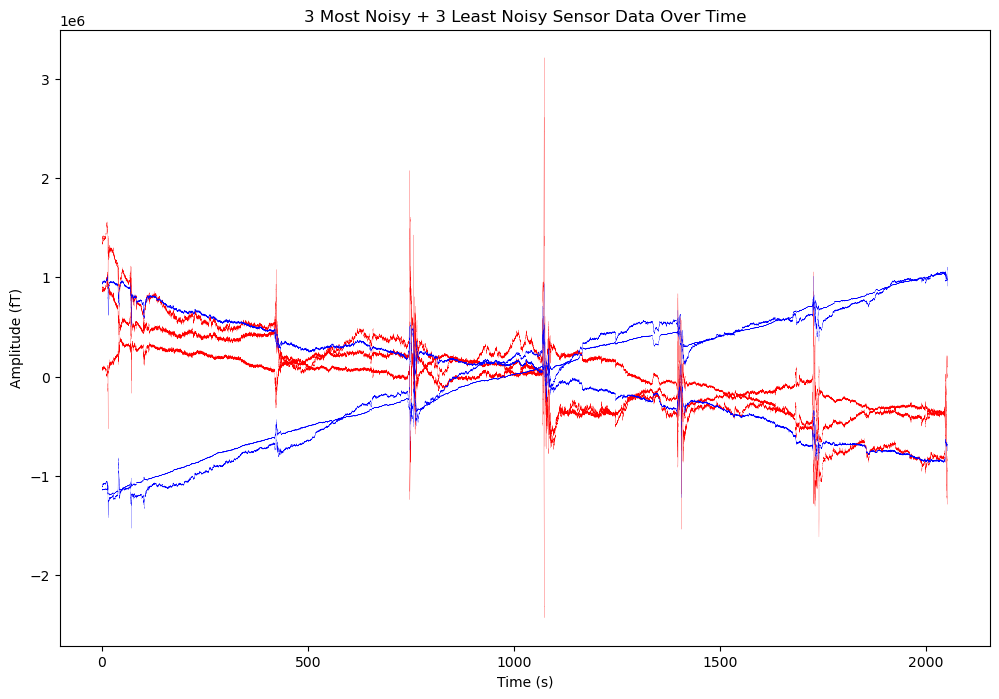

In [12]:
raw_plot_chans = raw.copy().pick_channels(plot_channels)
plt.figure(figsize=(12, 8))

for i, sensor_name in enumerate(most_noisy_channels):
    data, times = raw_plot_chans[sensor_name, :]
    data_zero_mean = data[0] - np.mean(data[0])  # Zero-mean 
    plt.plot(times, data_zero_mean*1e15, label=sensor_name, color='red',linewidth=0.1)

for i, sensor_name in enumerate(least_noisy_channels):
    data, times = raw_plot_chans[sensor_name, :]
    data_zero_mean = data[0] - np.mean(data[0])  # Zero-mean operation
    plt.plot(times, data_zero_mean*1e15, label=sensor_name, color='blue',linewidth=0.1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (fT)')
plt.title('3 Most Noisy + 3 Least Noisy Sensor Data Over Time')
#plt.legend()
plt.show()

#### To have closer view of the noise levels, plot a 5 s stretch of the data (from 1000 to 1005 s):

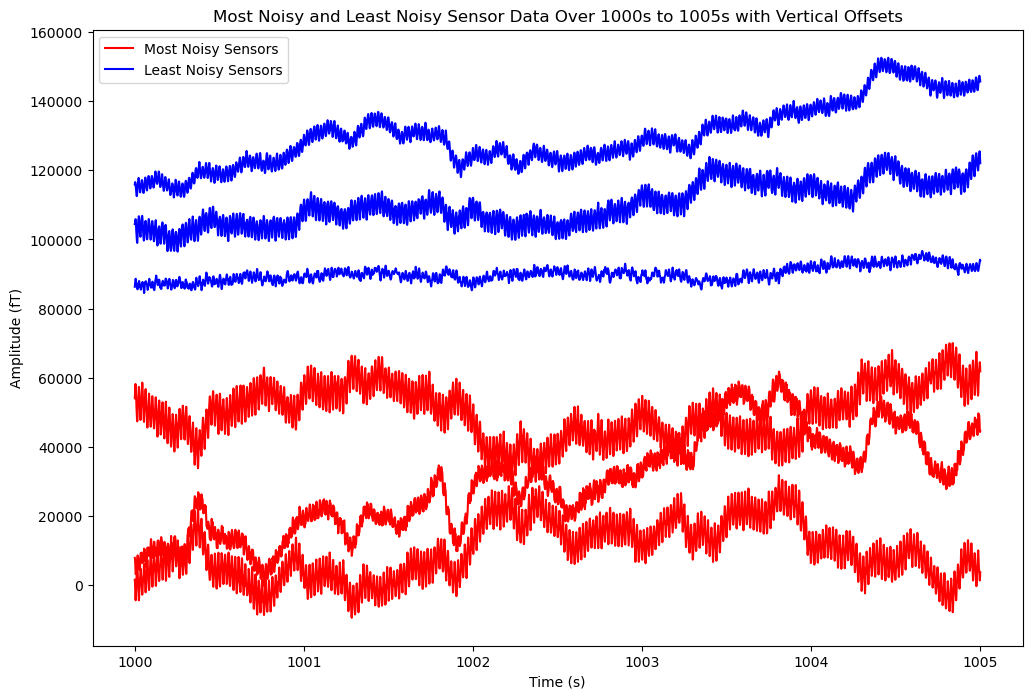

In [17]:
plt.figure(figsize=(12, 8))

# Define the interval for which you want to see the plot
t1 = 1000
t2 = 1005
Fs = 750  # Sampling Frequency

# Set DC offset for better viewing
noisy_offset = 10000  # increment for most_noisy sensors
non_noisy_offset = 20000  # increment for least_noisy sensors.

# Plot most noisy sensors
for i, sensor_name in enumerate(most_noisy_channels):
    data, times = raw_plot_chans[sensor_name, :]
    start_idx = int(np.round(t1 * Fs))
    end_idx = int(np.round(t2 * Fs))
    cropped_data = data[0][start_idx:end_idx]
    data_zero_mean = (cropped_data - np.mean(cropped_data)) * 1e15  
    data_zero_mean += noisy_offset + (i * non_noisy_offset)  # Offset by group
    plt.plot(times[start_idx:end_idx], data_zero_mean, color='red', label='Most Noisy Sensors' if i == 0 else "")

# Adjust offset 
least_noisy_base_offset = noisy_offset + (len(most_noisy_channels) * non_noisy_offset) + 20000  

# Plot least noisy sensors
for i, sensor_name in enumerate(least_noisy_channels):
    data, times = raw_plot_chans[sensor_name, :]
    start_idx = int(np.round(t1 * Fs))
    end_idx = int(np.round(t2 * Fs))
    cropped_data = data[0][start_idx:end_idx]
    data_zero_mean = (cropped_data - np.mean(cropped_data)) * 1e15  # Scale to fT
    data_zero_mean += least_noisy_base_offset + (i * non_noisy_offset)
    plt.plot(times[start_idx:end_idx], data_zero_mean, color='blue', label='Least Noisy Sensors' if i == 0 else "")

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (fT)')
plt.title(f'Most Noisy and Least Noisy Sensor Data Over {t1}s to {t2}s with Vertical Offsets')
plt.legend()
plt.show()


#### It is also possible to use the interactive tool in MNE Python for browsing the time course

In [18]:
## Sensor data plot
raw.plot(picks=plot_channels, title='3 most and 3 least noisy Sensor data', show=True)

Using qt as 2D backend.


<mne_qt_browser._pg_figure.MNEQtBrowser(0x21fce9c6f50) at 0x0000021FB7E81380>